# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [758]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Description

In [759]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [760]:
portfolio.describe()


,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [761]:
profile.head()


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [762]:
profile.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [763]:
profile.describe()


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [764]:
transcript.head()


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [765]:
transcript.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [766]:
transcript.describe()


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# cleaning the data

Lets check the nulls

In [767]:
portfolio.isnull().values.any()

False

In [768]:
df_portfolio.isnull().any()

channels      False
difficulty    False
duration      False
offer_id      False
offer_type    False
reward        False
email         False
mobile        False
social        False
web           False
dtype: bool

In [769]:
profile.isnull().values.any()

True

In [770]:
profile.isnull().any()

age                 False
became_member_on    False
gender               True
id                  False
income               True
dtype: bool

In [771]:
transcript.isnull().values.any()

False

In [772]:
transcript.isnull().any()

event     False
person    False
time      False
value     False
dtype: bool

# cleaning the portfolio database:

1- get dummy of channels

2- drop channels from columns

3- change the id to offer_id

In [773]:
df_portfolio = portfolio.copy()

In [774]:
channels_dummy = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
df_portfolio = pd.concat([df_portfolio, channels_dummy], axis=1)

In [775]:
df_portfolio = df_portfolio.rename(columns={'id':'offer_id'})

In [776]:
df_portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


# cleaning the profile database:

1- drop nans 'income'

2- drop 'age' = 118

3- creating range for ages and income

4- gettin g dummy from gender

5_ changing the format of 'became_member_on' to %Y%m%d

6- change 'id' to 'customer id'


In [777]:
df_profile = profile.copy()

In [778]:
i_g = pd.get_dummies(df_profile["gender"])

In [779]:
df_profile = pd.concat([df_profile, dummy_of_ages, dummy_of_income, i_g], axis=1, sort=False)

In [780]:
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

In [781]:
df_profile = df_profile.rename(columns={'id':'customer_id'})

In [782]:
df_profile.head()

,age,became_member_on,gender,customer_id,income,"(18, 40]","(40, 60]","(60, 80]","(80, 102]","(30000, 60000]","(60000, 80000]","(80000, 120000]",F,M,O
0,118.0,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,1,0,0,0,0,0.0,0.0,0.0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1,0,0,0,1,1.0,0.0,0.0
2,118.0,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,1,0,0,0,0,0.0,0.0,0.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1,0,0,0,1,1.0,0.0,0.0
4,118.0,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,1,0,0,0,0,0.0,0.0,0.0


# cleaning the transcript database:

1- changing 'person' to 'customer_id'

2- getting dummy from 'event'


In [783]:
df_transcript = transcript.copy()


In [784]:
df_transcript = df_transcript.rename(columns={'person':'customer_id'})


In [785]:
df_transcript['event'] = df_transcript['event'].str.replace(' ', '-')


In [786]:

dummy = pd.get_dummies(df_transcript['event'])
df_transcript = pd.concat([df_transcript, dummy], axis=1 )

In [787]:
df_transcript.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer-received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [788]:
df_transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_transcript.value]
df_transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df_transcript.value]


In [789]:
df_transcript.head()


,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer-received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# combining three database

In [790]:
merge1 = pd.merge(df_transcript, df_profile, on='customer_id')

In [791]:
merge1.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,...,"(18, 40]","(40, 60]","(60, 80]","(80, 102]","(30000, 60000]","(60000, 80000]","(80000, 120000]",F,M,O
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0,0,1,0,0,0,1,1.0,0.0,0.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0,0,1,0,0,0,1,1.0,0.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1,None,19.89,...,0,0,1,0,0,0,1,1.0,0.0,0.0
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0,0,1,0,0,0,1,1.0,0.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1,None,17.78,...,0,0,1,0,0,0,1,1.0,0.0,0.0


In [792]:
merge2 = pd.merge(merge1, df_portfolio, on='offer_id', how='left')

In [793]:
merge2.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,...,O,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1,None,19.89,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1,None,17.78,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [794]:
merge2.to_csv('data/data.csv', index=False)


In [795]:
merge3 = pd.read_csv('data/data.csv')


In [796]:
merge3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 33 columns):
event               306534 non-null object
customer_id         306534 non-null object
time                306534 non-null int64
value               306534 non-null object
offer-completed     306534 non-null int64
offer-received      306534 non-null int64
offer-viewed        306534 non-null int64
transaction         306534 non-null int64
offer_id            167581 non-null object
amount              138953 non-null float64
age                 306534 non-null float64
became_member_on    306534 non-null object
gender              272762 non-null object
income              272762 non-null float64
(18, 40]            306534 non-null int64
(40, 60]            306534 non-null int64
(60, 80]            306534 non-null int64
(80, 102]           306534 non-null int64
(30000, 60000]      306534 non-null int64
(60000, 80000]      306534 non-null int64
(80000, 120000]     306534 non-null i

# Data Exploration and Data Visualization

In [797]:
import matplotlib.pyplot as plt
import seaborn as sns

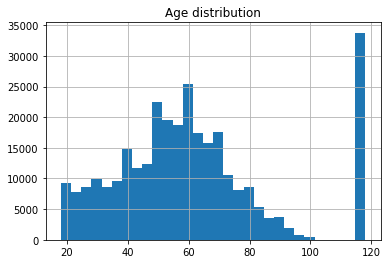

In [798]:
merge3.age.hist(bins = 30)
#xlabel: Age Group
#ylabel: Count
plt.title('Age distribution');


### Obviously age = 120 is outlier so it will be droped from data

### Besides, the age will be splited to 5 ranges to improve prediction of model

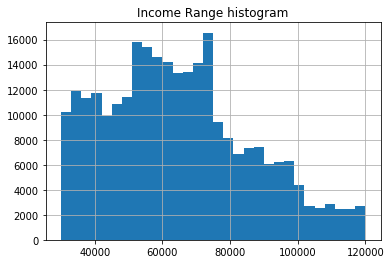

In [799]:
merge3.income.hist(bins = 30);
#xlabel: Income Range
#ylabel: Count
plt.title('Income Range histogram');

### The income will be splited to 4 ranges to improve prediction of model

In [800]:
splite_ages = pd.cut(x=merge3["age"], bins=[18, 40, 60, 80, 102])
dummy_of_ages = pd.get_dummies(splite_ages)

In [801]:
splite_income = pd.cut(x=df_profile["income"], bins=[30000, 60000, 80000,  120000])
dummy_of_income = pd.get_dummies(splite_income)

In [802]:
df_profile = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)


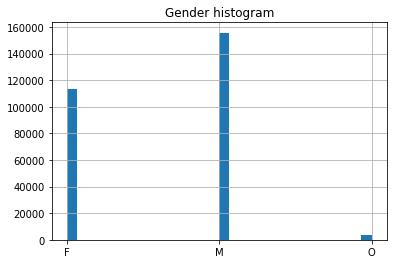

In [803]:
merge3.gender.hist(bins = 30);
#xlabel: Gender
#ylabel: Number of People
plt.title('Gender histogram');

### most of the customers consists of males

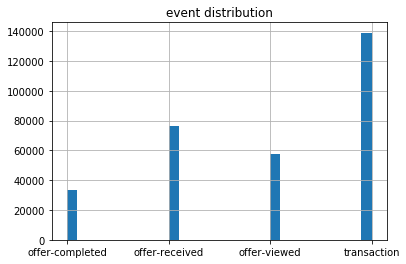

In [804]:
merge3.event.hist(bins = 30);
#xlabel:
#ylabel:
plt.title('event distribution');

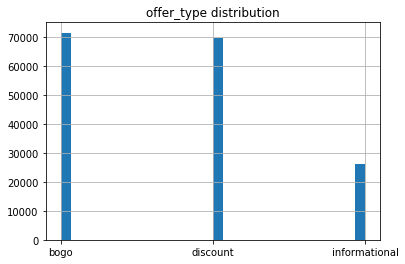

In [805]:
merge3.offer_type.hist(bins = 30);
#xlabel: 
#ylabel: 
plt.title('offer_type distribution');

In [806]:
receiving_offer = merge3[merge3['offer-received'] == 1].offer_type.value_counts()
viewing_offer = merge3[merge3['offer-viewed'] == 1].offer_type.value_counts()
completing_offer = merge3[merge3['offer-completed'] == 1].offer_type.value_counts()


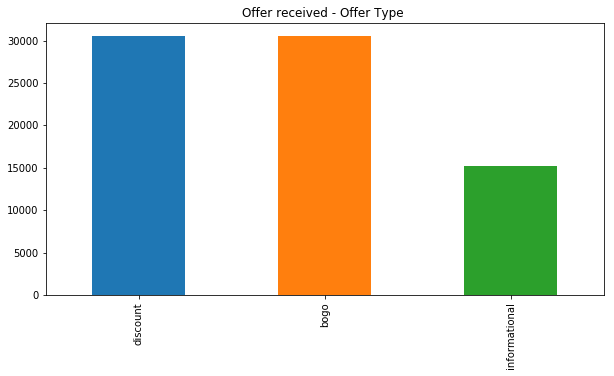

In [807]:
plt.subplot()
receiving_offer = merge3[merge3['offer-received'] == 1].offer_type.value_counts()
receiving_offer.plot(kind='bar', figsize=(10,5))
#ylabel:counts
#xlabel: Offer Type
plt.title('Offer received - Offer Type ');

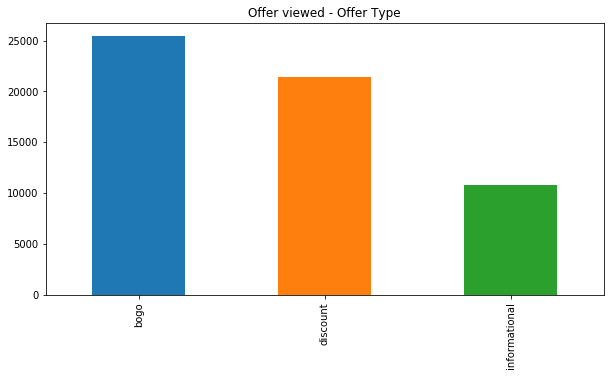

In [808]:
plt.subplot()
viewing_offer = merge3[merge3['offer-viewed'] == 1].offer_type.value_counts()
viewing_offer.plot(kind='bar', figsize=(10,5))
#ylabel:counts
#xlabel: Offer Type
plt.title('Offer viewed - Offer Type');

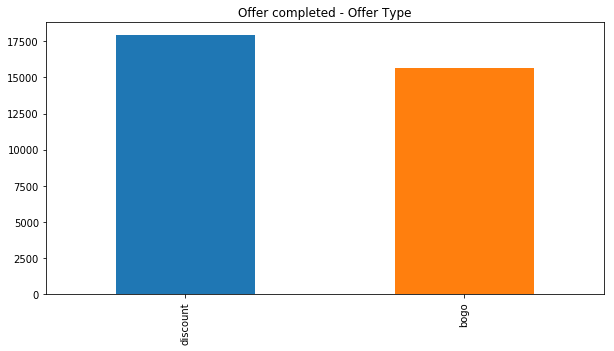

In [809]:
plt.subplot()
completing_offer = merge3[merge3['offer-completed'] == 1].offer_type.value_counts()
completing_offer.plot(kind='bar', figsize=(10,5))
#ylabel:counts
#xlabel: Offer Type
plt.title('Offer completed - Offer Type');

### As it is shown customers are more interested respectively in discount, bogo, and then information.

## Building the model

1- mapping offer_id, event, gender, offers

2- changing integers to float

3- implementing algorithms (KNN, ANN, Logestic Regression, Minimum distance classifier)

In [810]:
merge3.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,...,O,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1,NaN,19.89,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1,NaN,17.78,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [811]:
offer_id = merge3['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', nan,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [812]:
offer_to_dict = pd.Series(offer_id ).to_dict()
offer_to_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: nan,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [813]:
offer_to_dict = dict([(value, key) for key, value in offer_to_dict.items()]) 
offer_to_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 nan: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [814]:
merge3['offer_id'] = merge3['offer_id'].map(offer_to_dict)
merge3.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,...,O,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1,1,19.89,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,0,NaN,...,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1,1,17.78,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [815]:
merge3['offer_id'] = merge3['offer_id'].replace(1, np.nan)


In [816]:
merge3['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [817]:
event_ids = merge3['event'].unique()
event_ids

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'], dtype=object)

In [818]:
event_to_dict = pd.Series(event_ids).to_dict()
event_to_dict

{0: 'offer-received',
 1: 'offer-viewed',
 2: 'transaction',
 3: 'offer-completed'}

In [819]:
event_to_dict = dict([(value, key) for key, value in event_to_dict.items()]) 
event_to_dict

{'offer-received': 0,
 'offer-viewed': 1,
 'transaction': 2,
 'offer-completed': 3}

In [820]:
merge3['event_id'] = merge3['event'].map(event_to_dict)

In [821]:
genders = {'O': 0, 'M': 1, 'F': 2}
merge3['gender'] = merge3['gender'].map(genders)

In [822]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
merge3['offer_type'] = merge3['offer_type'].map(offers)

In [823]:
merge3.head(10)


,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,...,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0.0,NaN,...,"['web', 'email', 'mobile']",5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0.0,NaN,...,"['web', 'email', 'mobile']",5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1,NaN,19.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,0.0,NaN,...,"['web', 'email', 'mobile']",5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1,NaN,17.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,1,0,0,2.0,NaN,...,"['email', 'mobile', 'social']",0.0,3.0,2.0,0.0,1.0,1.0,1.0,0.0,0
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,1,0,2.0,NaN,...,"['email', 'mobile', 'social']",0.0,3.0,2.0,0.0,1.0,1.0,1.0,0.0,1
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},0,0,0,1,NaN,19.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},0,0,0,1,NaN,29.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},0,0,0,1,NaN,23.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [824]:
merge3['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [825]:
merge3['event_id'].value_counts()

2    138953
0     76277
1     57725
3     33579
Name: event_id, dtype: int64

In [826]:
merge3.dtypes

event                object
customer_id          object
time                  int64
value                object
offer-completed       int64
offer-received        int64
offer-viewed          int64
transaction           int64
offer_id            float64
amount              float64
age                 float64
became_member_on     object
gender              float64
income              float64
(18, 40]              int64
(40, 60]              int64
(60, 80]              int64
(80, 102]             int64
(30000, 60000]        int64
(60000, 80000]        int64
(80000, 120000]       int64
F                   float64
M                   float64
O                   float64
channels             object
difficulty          float64
duration            float64
offer_type          float64
reward              float64
email               float64
mobile              float64
social              float64
web                 float64
event_id              int64
dtype: object

In [827]:
merge3.isnull().any()

event               False
customer_id         False
time                False
value               False
offer-completed     False
offer-received      False
offer-viewed        False
transaction         False
offer_id             True
amount               True
age                 False
became_member_on    False
gender               True
income               True
(18, 40]            False
(40, 60]            False
(60, 80]            False
(80, 102]           False
(30000, 60000]      False
(60000, 80000]      False
(80000, 120000]     False
F                   False
M                   False
O                   False
channels             True
difficulty           True
duration             True
offer_type           True
reward               True
email                True
mobile               True
social               True
web                  True
event_id            False
dtype: bool

In [828]:
import numpy as np
np.sum(merge3.isnull())

event                    0
customer_id              0
time                     0
value                    0
offer-completed          0
offer-received           0
offer-viewed             0
transaction              0
offer_id            138953
amount              167581
age                      0
became_member_on         0
gender               33772
income               33772
(18, 40]                 0
(40, 60]                 0
(60, 80]                 0
(80, 102]                0
(30000, 60000]           0
(60000, 80000]           0
(80000, 120000]          0
F                        0
M                        0
O                        0
channels            138953
difficulty          138953
duration            138953
offer_type          138953
reward              138953
email               138953
mobile              138953
social              138953
web                 138953
event_id                 0
dtype: int64

In [829]:
merge3.dtypes

event                object
customer_id          object
time                  int64
value                object
offer-completed       int64
offer-received        int64
offer-viewed          int64
transaction           int64
offer_id            float64
amount              float64
age                 float64
became_member_on     object
gender              float64
income              float64
(18, 40]              int64
(40, 60]              int64
(60, 80]              int64
(80, 102]             int64
(30000, 60000]        int64
(60000, 80000]        int64
(80000, 120000]       int64
F                   float64
M                   float64
O                   float64
channels             object
difficulty          float64
duration            float64
offer_type          float64
reward              float64
email               float64
mobile              float64
social              float64
web                 float64
event_id              int64
dtype: object

In [830]:

merge3 = merge3.drop(["age", "gender", "income","amount","channels","value" ], axis=1)

In [831]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

In [832]:
x= merge3.drop(['offer_id', 'difficulty' , 'duration' , 'offer_type','reward','email','mobile', 'social','web',
       'became_member_on','transaction','customer_id','offer-viewed','offer-received','offer-completed','event','event_id'], axis=1)
y = merge3['event_id']

In [833]:
x_columns = list(x.columns)
x_columns

['time',
 '(18, 40]',
 '(40, 60]',
 '(60, 80]',
 '(80, 102]',
 '(30000, 60000]',
 '(60000, 80000]',
 '(80000, 120000]',
 'F',
 'M',
 'O']

In [834]:
x.dtypes

time                 int64
(18, 40]             int64
(40, 60]             int64
(60, 80]             int64
(80, 102]            int64
(30000, 60000]       int64
(60000, 80000]       int64
(80000, 120000]      int64
F                  float64
M                  float64
O                  float64
dtype: object

In [835]:
for i in x_columns[1:]:
    
    x[i] = x[i].astype(float)
x_new = x

In [836]:
x_new.dtypes

time                 int64
(18, 40]           float64
(40, 60]           float64
(60, 80]           float64
(80, 102]          float64
(30000, 60000]     float64
(60000, 80000]     float64
(80000, 120000]    float64
F                  float64
M                  float64
O                  float64
dtype: object

In [837]:
y.head()


0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

In [838]:
#Split into 70% train and 30% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [839]:
Scaler = StandardScaler()
Scaler.fit(x)
x_scaled = Scaler.transform(x)

In [840]:
y_test.value_counts()

2    41412
0    23051
1    17315
3    10183
Name: event_id, dtype: int64

### Checking if objective is balance or not

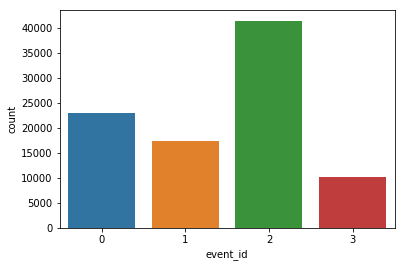

In [841]:
import seaborn as sns

sns.countplot(y_test)

In [842]:
#implementing KNN model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score


# Instantiate
# Fit
# Predict and score the model

modelKNN = KNeighborsClassifier(n_neighbors=8)
modelKNN.fit(x_train, y_train);
y_train_predKNN =  modelKNN.predict(x_train)
y_test_predKNN = modelKNN.predict(x_test)

Acc_KNN = accuracy_score(y_test, y_test_predKNN)
F1_Score_KNN = f1_score(y_test, y_test_predKNN, average='weighted')
Precision_KNN = precision_score(y_test, y_test_predKNN,average='weighted')
Recall_KNN = recall_score(y_test, y_test_predKNN,average='weighted')

Acc_KNN_train = accuracy_score(y_train, y_train_predKNN)
F1_Score_KNN_train = f1_score(y_train, y_train_predKNN, average='weighted')
Precision_KNN_train = precision_score(y_train, y_train_predKNN,average='weighted')
Recall_KNN_train = recall_score(y_train, y_train_predKNN,average='weighted')

In [843]:
#implementing ANN model

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(13,12,13,12,13,12), random_state=1, activation='tanh')

# Instantiate
# Fit
# Predict and score the model

clf.fit(x_test, y_test)
clf.predict(x_test)
y_train_predANN =  clf.predict(x_train)
y_test_predANN= clf.predict(x_test)

Acc_ANN = accuracy_score(y_test, y_test_predANN)
F1_Score_ANN = f1_score(y_test, y_test_predANN, average='weighted')
Precision_ANN = precision_score(y_test, y_test_predANN,average='weighted')
Recall_ANN = recall_score(y_test, y_test_predANN,average='weighted')


Acc_ANN_train = accuracy_score(y_train, y_train_predANN)
F1_Score_ANN_train = f1_score(y_train, y_train_predANN, average='weighted')
Precision_ANN_train = precision_score(y_train, y_train_predANN,average='weighted')
Recall_ANN_train = recall_score(y_train, y_train_predANN,average='weighted')

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [844]:
#implementing LogisticRegression model

from sklearn.linear_model import LogisticRegression

# Instantiate
# Fit
# Predict and score the model

modelLR = LogisticRegression(max_iter=100)
modelLR.fit(x_train,y_train)
y_train_predLR =  modelLR.predict(x_train)
y_test_predLR  = modelLR.predict(x_test)

Acc_LR = accuracy_score(y_test, y_test_predLR)
F1_Score_LR  = f1_score(y_test, y_test_predLR, average='weighted')
Precision_LR  = precision_score(y_test, y_test_predLR,average='weighted')
Recall_LR = recall_score(y_test, y_test_predLR,average='weighted')

Acc_LR_train = accuracy_score(y_train, y_train_predLR)
F1_Score_LR_train = f1_score(y_train, y_train_predLR, average='weighted')
Precision_LR_train = precision_score(y_train, y_train_predLR,average='weighted')
Recall_LR_train = recall_score(y_train, y_train_predLR,average='weighted')

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [845]:
#implementing MDC model

from sklearn.neighbors import NearestCentroid
modelMDC = NearestCentroid()

# Instantiate
# Fit
# Predict and score the model

modelMDC.fit(x_train, y_train)
y_train_predMDC =  modelMDC.predict(x_train)
y_test_predMDC = modelMDC.predict(x_test)

Acc_MDC = accuracy_score(y_test, y_test_predMDC)
F1_Score_MDC = f1_score(y_test, y_test_predMDC, average='weighted')
Precision_MDC = precision_score(y_test, y_test_predMDC,average='weighted')
Recall_MDC = recall_score(y_test, y_test_predMDC,average='weighted')

Acc_MDC_train = accuracy_score(y_train, y_train_predMDC)
F1_Score_MDC_train = f1_score(y_train, y_train_predMDC, average='weighted')
Precision_MDC_train = precision_score(y_train, y_train_predMDC,average='weighted')
Recall_MDC_train = recall_score(y_train, y_train_predMDC,average='weighted')

# Results:

In [846]:
print(Acc_KNN)
print(F1_Score_KNN)
print(Precision_KNN)
print(Recall_KNN)

0.664596948707
0.614878804376
0.597056284176
0.664596948707


In [847]:
print(Acc_ANN)
print(F1_Score_ANN)
print(Precision_ANN)
print(Recall_ANN)

0.490762388404
0.364150483926
0.51544658011
0.490762388404


In [848]:
print(Acc_LR)
print(F1_Score_LR)
print(Precision_LR)
print(Recall_LR)

0.451898087233
0.295551376283
0.28928884765
0.451898087233


In [849]:
print(Acc_MDC)
print(F1_Score_MDC)
print(Precision_MDC)
print(Recall_MDC)

0.215895868901
0.163701100504
0.444825508755
0.215895868901


# Conclusion:

### First we described the data, then we cleaned and visualized to make the analze more convenient, then the model was bulit to make the prediction event: (string) offer received, offer viewed, transaction, offer completed.
### 4 different algorithms which includes KNN, ANN, LR, and MDC are implemenetd to to get the highest accuracy, but due to the imbalanced data the highest accuracy was KNN by almost 66% accuracy. 